In [1]:
#import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection  import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, mean_squared_error

## Kernel Regression Alternative Coding

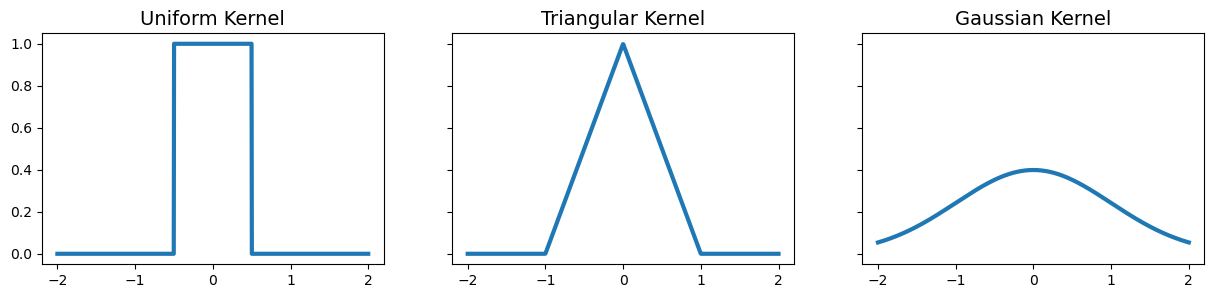

In [2]:
def U(x):
  return 1*(np.abs(x) <= 0.5)

def T(x):
  return 1*(1-np.abs(x))*(np.abs(x) <= 1)

def G(x):
  return np.exp(-x**2/2)/np.sqrt(2*np.pi)

fig, axes = plt.subplots(1, 3, figsize=(15, 3), sharey=True)
t = np.linspace(-2, 2, 1000)

axes[0].plot(t, U(t), lw=3)
axes[0].set_title("Uniform Kernel", fontsize=14)
axes[1].plot(t, T(t), lw=3)
axes[1].set_title("Triangular Kernel", fontsize=14)
axes[2].plot(t, G(t), lw=3)
axes[2].set_title("Gaussian Kernel", fontsize=14)
plt.show()

### Alternative method of creating kernel regression without scikit-fda

In [3]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.estimator_checks import check_estimator
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

class KernelRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, K=G, h=1):
#__init__ is like a special setup method that Python calls automatically when you create a new object from a class. 
# It's used to initialize the object's initial state.
        self.K = K #defining Kernel for the object self
        self.h = h #defining bandwidth for the object self

    def fit(self, X, y):
        X, y = check_X_y(X, y)
#check_X_y as a helpful assistant that makes sure your data is good to go before you start training
#your machine learning models. It helps prevent errors and ensures your models can learn from your data effectively.
        self.X_ = X
        self.y_ = y
        self.n_features_in_ = X.shape[1]
        return self

    def predict(self, X):
        check_is_fitted(self)
        X = check_array(X)
        dists = np.linalg.norm(X[:, np.newaxis, :] - self.X_[np.newaxis, :, :], axis=2)
        # dists = np.linalg.norm(X.reshape(X.shape[0], 1, X.shape[1])
        #  - self.X_.reshape(1, self.X_.shape[0], self.X_.shape[1]), axis=2)
        weights = self.K(dists/self.h)
        y_pred = (weights @ self.y_)/weights.sum(axis=1)
        return y_pred

check_estimator(KernelRegressor())

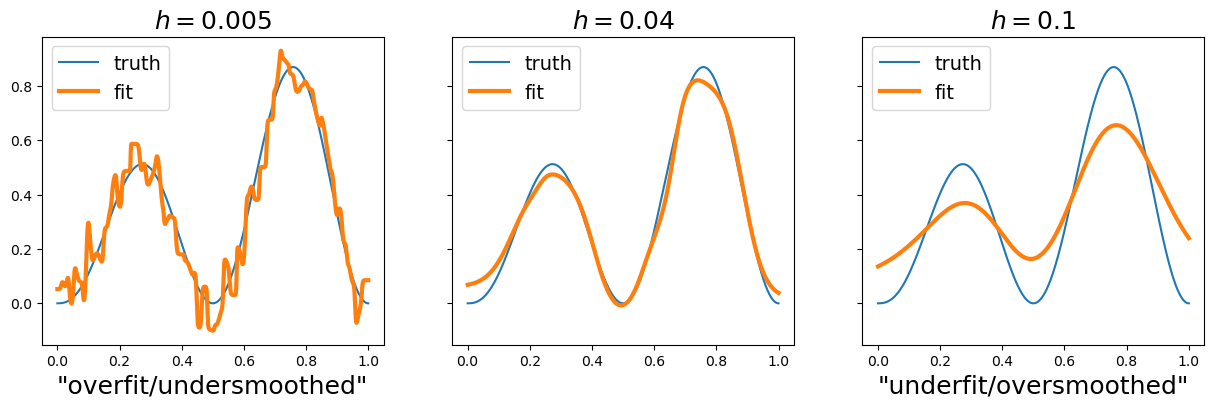

In [4]:
def f(x):
    return np.sqrt(x)*np.sin(2*np.pi*x)**2

def make_data(size, s=0.1, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    x = np.random.uniform(size=size)
    y = f(x) + s*np.random.normal(size=size)
    return x, y

x, y = make_data(100, random_state=42)
X = x.reshape(-1, 1)

t = np.linspace(0, 1, 1000)
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

model = KernelRegressor(h=0.005)
model.fit(X, y)
ax = axes[0]
ax.plot(t, f(t), label="truth")
ax.plot(t, model.predict(t.reshape(-1, 1)), lw=3, label="fit")
ax.set_xlabel('"overfit/undersmoothed"', fontsize=18)
ax.legend(loc="upper left", fontsize=14)
ax.set_title("$h=0.005$", fontsize=18)

model = KernelRegressor(h=0.04)
model.fit(X, y)
ax = axes[1]
ax.plot(t, f(t), label="truth")
ax.plot(t, model.predict(t.reshape(-1, 1)), lw=3, label="fit")
ax.legend(loc="upper left", fontsize=14)
ax.set_title("$h=0.04$", fontsize=18)

model = KernelRegressor(h=0.1)
model.fit(X, y)
ax = axes[2]
ax.plot(t, f(t), label="truth")
ax.plot(t, model.predict(t.reshape(-1, 1)), lw=3, label="fit")
ax.set_xlabel('"underfit/oversmoothed"', fontsize=18)
ax.legend(loc="upper left", fontsize=14)
ax.set_title("$h=0.1$", fontsize=18)

plt.show()

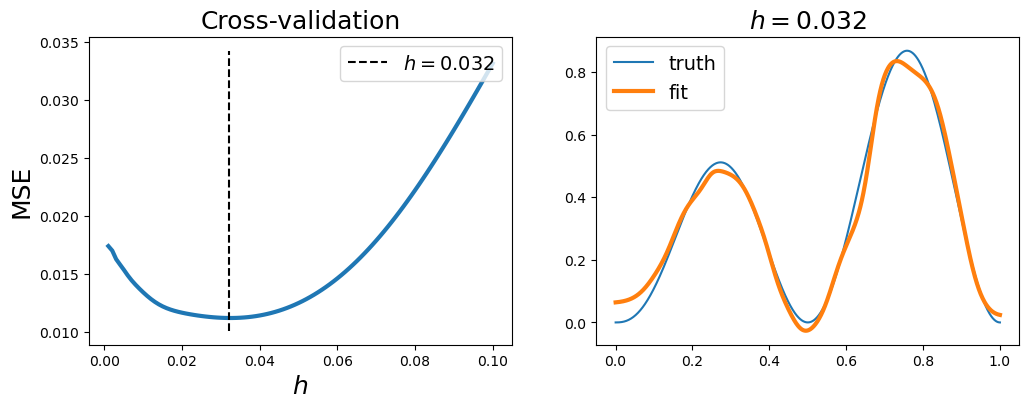

In [5]:
from sklearn.model_selection import GridSearchCV

x, y = make_data(100, random_state=42)
X = x.reshape(-1, 1)

hs = np.arange(0.001, 0.101, 0.001)


param_grid = {"h": hs}
search = GridSearchCV(KernelRegressor(), param_grid=param_grid, scoring="neg_mean_squared_error", cv=5)
search.fit(X, y)
h = search.best_params_["h"]
model = search.best_estimator_

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 4))

ax0.plot(hs, -search.cv_results_["mean_test_score"], lw=3)
ax0.plot([h, h], ax0.get_ylim(), "k--", label=f"$h={h}$")
ax0.set_xlabel("$h$", fontsize=18)
ax0.set_ylabel("MSE", fontsize=18)
ax0.legend(fontsize=14, loc="upper right")
ax0.set_title("Cross-validation", fontsize=18)
y0, y1 = ax0.get_ylim()

t = np.linspace(0, 1, 1000)
ax1.plot(t, f(t), label="truth")
ax1.plot(t, model.predict(t.reshape(-1, 1)), lw=3, label="fit")
ax1.legend(loc="upper left", fontsize=14)
ax1.set_title(f"$h={h}$", fontsize=18)

plt.show()

In [6]:
import pandas as pd
pd.DataFrame(search.cv_results_)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_h,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.000000,0.000000,0.000206,0.000412,0.001,{'h': 0.001},-0.012928,-0.021942,-0.022093,-0.009323,-0.020607,-0.017379,0.005257,68
1,0.000000,0.000000,0.000207,0.000414,0.002,{'h': 0.002},-0.012690,-0.020913,-0.021466,-0.009202,-0.020664,-0.016987,0.005061,66
2,0.000000,0.000000,0.000413,0.000507,0.003,{'h': 0.003},-0.013106,-0.019002,-0.020950,-0.008611,-0.019592,-0.016252,0.004670,63
3,0.000000,0.000000,0.000202,0.000404,0.004,{'h': 0.004},-0.013855,-0.018065,-0.020249,-0.008279,-0.018480,-0.015785,0.004300,61
4,0.000399,0.000489,0.000000,0.000000,0.005,{'h': 0.005},-0.014188,-0.017329,-0.019037,-0.008216,-0.017863,-0.015326,0.003900,58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.000000,0.000000,0.000200,0.000400,0.096,{'h': 0.096},-0.019136,-0.028576,-0.051798,-0.026208,-0.028360,-0.030816,0.011036,96
96,0.000000,0.000000,0.000200,0.000400,0.097,{'h': 0.097},-0.019574,-0.029087,-0.052624,-0.026773,-0.028927,-0.031397,0.011164,97
97,0.000000,0.000000,0.000200,0.000400,0.098,{'h': 0.098},-0.020016,-0.029602,-0.053449,-0.027342,-0.029500,-0.031982,0.011291,98
98,0.000200,0.000400,0.000200,0.000400,0.099,{'h': 0.099},-0.020460,-0.030120,-0.054272,-0.027914,-0.030077,-0.032569,0.011415,99


### Trigonometric polynomial regression

Approximate an unknown function $f(x)$, from noisy samples

$$(x_1,y_1),\ldots,(x_n,y_n)\in\mathbb{R}\times\mathbb{R},$$

by a function of the form

$$
\hat{f}(x) = a_0 + \sum_{j=1}^na_j\cos(j x) + \sum_{j=1}^na_{n+j}\sin(j x).\tag{$*$}
$$

To accomplish this, we reduce the problem to linear regression using a **data transformation**. Let

$$
z_j = \begin{cases}
\cos(jx) &\text{if $1\leq j\leq n$,}\\
\sin(jx) &\text{if $n+1\leq j\leq 2n$.}\\
\end{cases}
$$

Then $(*)$ becomes

$$
\hat{f}(x) = a_0 + \sum_{j=1}^{2n} a_j z_j.
$$

Thus, $\hat{f}$ is **linear** in the new variables $z_1,\ldots,z_n$, the coefficients $a_0,a_1,\ldots,a_n$ can be estimated by linear regression.

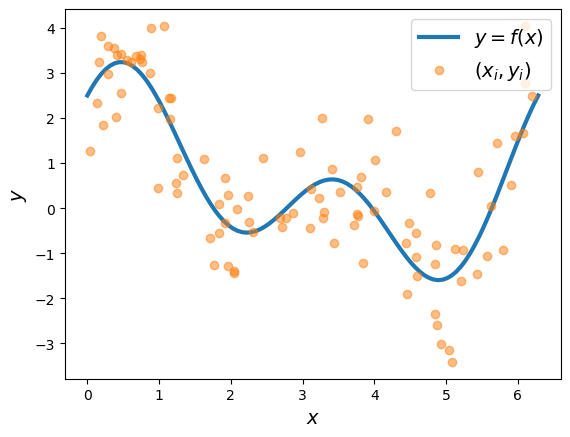

In [7]:
np.random.seed(42)
d = 2
intercept = np.random.normal()

def f(x):
    freqs = np.arange(1, d+1).reshape(1, -1)
    cos_features = np.cos(freqs*x.reshape(-1, 1))
    sin_features = np.sin(freqs*x.reshape(-1, 1))
    y = intercept + cos_features.sum(axis=1) + sin_features.sum(axis=1)
    return y

x = 2*np.pi*np.random.uniform(size=100)
X = x.reshape(-1, 1)
y = f(x) + 1.0*np.random.normal(size=100)
t = np.linspace(0, 2*np.pi, 100)
plt.plot(t, f(t), lw=3, label="$y=f(x)$")
plt.plot(x, y, 'o', alpha=0.5, label="$(x_i,y_i)$")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("$x$", fontsize=14)
plt.ylabel("$y$", fontsize=14)
plt.show()

print(d)
freqs = np.arange(1, d+1).reshape(1, -1)
cos_features = np.cos(freqs*X)
sin_features = np.sin(freqs*X)
Z = np.hstack([cos_features, sin_features]) # Trigonometic features
print(Z.shape);

## Alternative coding for trigonometric polynomial regression

In [8]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.estimator_checks import check_estimator
from sklearn.utils.validation import check_array, check_is_fitted

class TrigFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, degree=1):
        self.degree = degree

    def fit(self, X, y=None):
        X = check_array(X)
        self.n_features_in_ = X.shape[1]
        return self

    def transform(self, X):
        X = check_array(X)
        if X.shape[1] != self.n_features_in_:
          raise ValueError("X.shape[1] != self.n_features_in_")
        # if X.shape[1] > 1:
        #   raise ValueError("TrigFeatures assumes 1-dimensional data.")
        freqs = np.arange(1, self.degree + 1).reshape(1, -1)
        #reshape(-1) refers to an unknown dimension that the reshape() function calculates for you.
        cos_features = np.cos(freqs*X)
        sin_features = np.sin(freqs*X)
        Z = np.hstack([cos_features, sin_features])
        #Stack arrays in sequence horizontally (column wise).
        return Z

check_estimator(TrigFeatures())

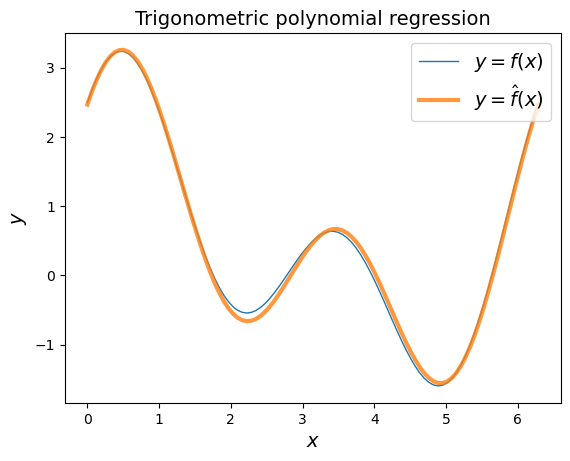

In [9]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

model = make_pipeline(TrigFeatures(degree=2), LinearRegression())
model.fit(X, y)
t = np.linspace(0, 2*np.pi, 100)
plt.plot(t, f(t), lw=1, label="$y=f(x)$")
plt.plot(t, model.predict(t.reshape(-1, 1)), lw=3, label="$y=\hat{f}(x)$", alpha=0.8)
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("$x$", fontsize=14)
plt.ylabel("$y$", fontsize=14)
plt.title("Trigonometric polynomial regression", fontsize=14)
plt.show()

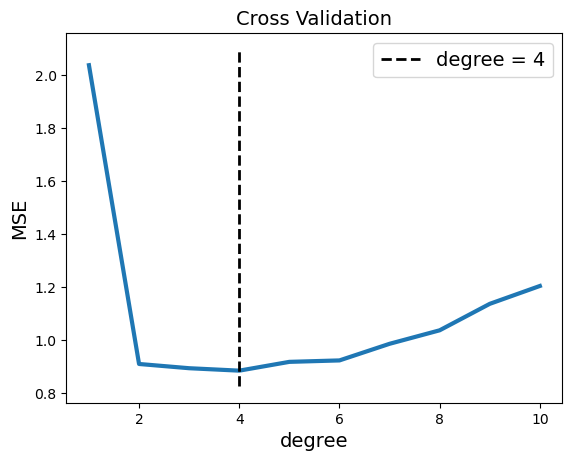

In [10]:
from sklearn.model_selection import GridSearchCV

param_grid = {"trigfeatures__degree": np.arange(1, 11)}
model = make_pipeline(TrigFeatures(), LinearRegression())
search = GridSearchCV(model, param_grid=param_grid, scoring="neg_mean_squared_error", cv=5)
search.fit(X, y)
degree = search.best_params_["trigfeatures__degree"]

plt.plot(param_grid["trigfeatures__degree"], -search.cv_results_["mean_test_score"], lw=3)
plt.plot([degree, degree], plt.ylim(), 'k--', lw=2, label=f"degree = {degree}")
plt.xlabel("degree", fontsize=14)
plt.ylabel("MSE", fontsize=14)
plt.title("Cross Validation", fontsize=14)
plt.legend(loc="upper right", fontsize=14)

plt.show()